<div style="text-align: right"> VUONG Christophe </div>

# <center>Project: Monte-Carlo methods for computations of integral on $\mathbb{R}^d$ </center>

# Table of contents
I. [Build an MC algorithm that computes the mean of any given distribution](#section1)
1. [Monte-Carlo basic method](#paragraph1)
2. [Accept-reject algorithm](#paragraph2)
3. [Metropolis-Hasting](#paragraph3)

II. [Importance sampling methods](#section2)
4. [Kullback-Leibler estimation](#paragraph4)
5. [AIS with Gaussian or Student distributions](#paragraph5)
6. [Kernel for non parametric AIS](#paragraph6)

II. [Control variates](#section3)

IV. [Performances of the algorithms](#section4)
7. [Comparison of algorithms to the basic MC methods with uniform sampling on the cube $[0,10]^2$](#paragraph7)
8. [A larger dimension?](#paragraph8)

V. [Annex](#section5)

VI. [Sources](#section6)

In this report, the used languages are Python and Latex for equations.

In [1]:
import numpy as np
import math
from scipy import integrate
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import multinomial
from matplotlib import pyplot as plt
%matplotlib inline 
import time
from sklearn.cluster import KMeans

# I) Build an MC algorithm that computes the mean of any given distribution<a name="section1"></a>
Here we will train your algorithm on the following density mixture_d_2. If your algorithm needs to be restricted to a compact set. You can choose $[0,10]^2$. You will first present your algorithm and then evaluate its performance according to different budget $(1000,5000,10000)$ using the averaged squared error computed over, at least, $50$ trials. If $A_1,\ldots, A_{50}$ are realization of your algorithm and $\mu$ is the true value, the average squared error computed over $50$ trials is
$$\frac{1}{50} \sum_{i=1} ^{50} (A_i - \mu)^2$$ 


In [7]:
#gaussian mixture on the unit cube
def mixture_d_2(x):
    x1 = x - np.matrix([3,7])
    x2 = x - np.matrix([7,2])
    x3 = x - np.matrix([7,7])
    return (.2 * np.prod(norm.pdf(x1)) + .4 * np.prod(norm.pdf(x2)) + .4 * np.prod(norm.pdf(x3))) 

def mixture_d_2d(x):
    return (.2 * multivariate_normal.pdf(x,[3,7],np.identity(2)) + .4 * multivariate_normal.pdf(x,[7,2],np.identity(2)) + .4 * multivariate_normal.pdf(x,[7,7],np.identity(2))) 

Let compute the mean of given distribution. 
$$f_1(x) = 0.2 \times \frac{1}{2\pi}e^{-\frac{1}{2}[(x_1 - 3)^2 + (x_2 - 7)^2]}+ 0.4 \times \frac{1}{2\pi} e^{-\frac{1}{2}[(x_1 - 7)^2 + (x_2 - 2)^2]} + 0.4 \times \frac{1}{2\pi}e^{-\frac{1}{2}[(x_1 - 7)^2 + (x_2 - 7)^2]} $$


Hence the mean $\mu$ is given by:
$$\mu_1 = 0.2 \times 3 + 0.4 \times 7 + 0.4 \times 7 = 6.2$$
$$\mu_2 = 0.2 \times 7 + 0.4 \times 2 + 0.4 \times 7 = 5$$

We will use those values of integrals to test the algorithms below. Because we mainly use Gaussian densities, those values are those we aim at. Uniform laws can only evaluate an integral on a compact.

The functions below return the error as described. We compare the methods given the same budget for evaluations.

In [4]:
def identity(x):
    return x

def uniform(x,bound,dim):
    n = len(x)
    for i in range(n):
        if (x[i] < -bound and x[i] > bound):
            return 0
    return 1 / (2 * bound)**(dim) 

def errorMethod(f,dens,mean = [6.2,5],N=10000,dim = 2,fun=identity,bound = 10,n_iter=50):
    myError = 0
    myMean = np.zeros(dim)
    a = time.time()
    for k in range(n_iter):
        value = f(dens,N,fun,dim,bound)
        myMean += value
        myError += np.linalg.norm(value - mean)**2
    c = time.time() - a
    myMean = myMean / n_iter   
    myError = myError / n_iter
    string = str(f)
    print(string, " mean: ",myMean)
    print("Standard error: ",math.sqrt(myError))
    return (myError , c)


def errorMethodMCM(f,dens,Q,u,mean = [6.2,5],N=10000,dim = 2,fun=identity,n_iter=50):
    myError = 0
    myMean = np.zeros(dim)
    a = time.time()
    nb = len(u)
    nb_iter = n_iter // nb
    for k in range(nb_iter):
        values = f(dens,N,Q,u,fun,dim)
        for i in range(nb):
            value = values[i,:]
            myMean += value
            myError += np.linalg.norm(value - mean)**2
    c = time.time() - a
    n_iter = nb_iter * nb
    myMean = myMean / n_iter   
    myError = myError / n_iter
    string = str(f)
    print(string, " mean: ",myMean)
    print("Standard error: ",math.sqrt(myError))
    return (myError , c)

def errorMethodAIS(f,dens,dist="Student",mean = [6.2,5],N=10000,dim = 2,fun=identity,bound = 10,nb = 100,n_iter=50):
    myMean = np.zeros(dim)
    a = time.time()
    errorAIS = np.zeros(nb)
    for k in range(n_iter):
        values = f(dens,N,fun,dim,nb,dist,bound)
        for i in range(nb):
            value = values[i,:]
            errorAIS[i] += np.linalg.norm(value - mean)**2
        myMean += values[nb-1,:]
    c = time.time() - a
    myMean = myMean / n_iter   
    errorAIS = errorAIS / n_iter
    myError = errorAIS[nb-1]
    plt.plot(range(1,nb+1),errorAIS)
    plt.title("Average quadratic error at each AIS iteration")
    plt.xlabel("Step")
    plt.ylabel("Average quadratic error")
    plt.show()
    string = str(f)
    print(string, " mean: ",myMean)
    print("Standard error: ",math.sqrt(myError))
    return (myError, c)

#2D only
def plotter(q,x,N = 500,xmin = 0,xmax = 10,ymin = 0,ymax = 10,points = True):
    z = np.zeros([N,N])
    y = np.zeros([N,N])
    u = np.zeros([N,N])
    x1 = np.linspace(xmin,xmax,N)
    y1 = np.linspace(ymin,ymax,N)
    for i in range(N):
        for j in range(N):
            z[i,j] = x1[i]
            y[i,j] = y1[j]
            u[i,j] = q([x1[i],y1[j]])
    plt.pcolormesh(z,y,u)
    if points:
        plt.scatter(x[:,0], x[:,1], c = 'red')
    #plt.xlim((0,10))
    #plt.ylim((0,10))
    plt.show()

The basic Monte-Carlo function is given just below and the goal is to beat its performance with algorithm that converges quicker to the expect value. We can also compare the density mapping to that below:

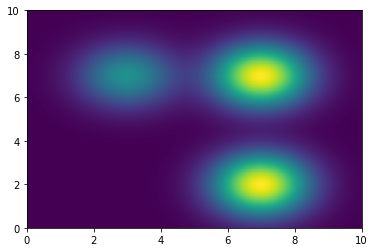

In [12]:
plotter(mixture_d_2,[0,0])

## 1) Monte-Carlo basic method<a name="section1"></a>

Because we do not know how to generate points from a density $f$, we cannot compute the classic Monte-Carlo estimator:
$$\tilde{I}_n = \frac{1}{n} X_i$$ with $X_i$ i.i.d generated by $f$

_Idea:_ Approximate $I = \int xf(x)dx \simeq \int xf(x)\mathbb{1}_{\{ x \in [-M,M]^d\}}dx = \int M^d xf(x)\frac{\mathbb{1}_{\{ x \in [-M,M]^d\}}}{M^d}dx$ 

The large number law states that with $X_i \sim Uniform[-M,M]$ , $\hat{I}_n = M^d \frac{1}{n} X_i\:f(X_i)$ almost surely converges to $I$. So we derive an algorithm of Monte-Carlo :

In [6]:
# [-bound, bound]^dim a compact that approximates the support of f
def MC(phi,n,fun = identity,dim = 2,bound = 10):
    #uniform law
    x = 2 * bound * np.random.random_sample((n,dim)) - bound
    f = lambda y : phi(y) * fun(y)
    r = np.zeros(dim)
    for i in range(n):
        r += f(x[i,:])
    return r / n * (2 * bound)**dim

In [56]:
MC(mixture_d_2,10000,dim = 2)

array([6.5780095 , 5.30107434])

In [58]:
MC(mixture_d_5,100000,dim = 5,bound = 100)

array([ 4.73885095,  4.76559537, -0.16848709, -0.1864939 , -0.05914954])

## 2) Accept-reject algorithm<a name="paragraph2"></a>

One can also think of reject method to compute the density and use Monte-Carlo method with that simulation of the law. We have an upper bound for the density by a uniform law. So according to the lecture notes, as $f$ is a sum of Gaussians, $|f| \leq \frac{1}{(2\pi)^d}$

In [41]:
def accept_reject(f,n,fun = identity,dim = 2,bound = 10):
    c =  (bound / math.pi)**(dim)
    x = 2 * bound * np.random.random_sample((n,dim)) - bound
    u = np.random.random_sample(n)
    integral = np.zeros(dim)
    nb_acc = 0
    for i in range(n):
        if f(x[i,:]) * (2 * math.pi)**(dim/2) >= u[i]:
            nb_acc += 1
            integral += fun(x[i,:])
            plt.scatter(x[i,0], x[i,1], c = 'red')
    plt.show()
    print("Stats= ",nb_acc / n," Accept Probability = ",1 / c)
    return integral / nb_acc

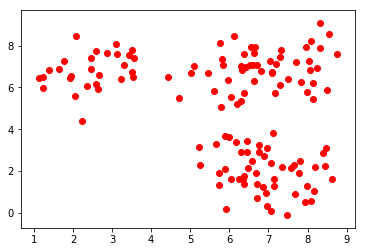

Stats=  0.0131  Accept Probability =  0.09869604401089356


array([5.94496996, 4.95787743])

In [42]:
accept_reject(mixture_d_2,10000)

With that method, we already have a look of the density if we know more or less an intervall that contains all the important value of the support. But, we lose a lot of points as theory confirms since the very low accept probability.

## 3) Metropolis-Hasting<a name="paragraph3"></a>

_Idea:_ Use Markov Chains to progressively draw points from the density.

We can use normal distribution for the initial drawing of points as to respect the condition concerning the support.

**Outputs:** Points generated by an approximation of the density from which we can calculate the classic Monte-Carlo estimator.

Since the very first points are randomly taken, one may exclude them from the mean computation. However, in practise given the fact we take a lot of points, it does not matter as much as expected.

In order to make the method robust, I tested for several initial probability measures. 

In [44]:
def Markov_chain(x0,dim,Q,f,n): #symetric kernel here, simplification
    x = np.zeros((n,dim))
    x[0,:] = x0
    for k in range(n-1):
        y = Q(x[k,:])
        r = min(1,f(y)/f(x[k,:]))
        w = np.random.binomial(1,r)
        if w == 1:
            x[k+1,:] = y
        else:
            x[k+1,:] = x[k,:]
    return x

# different initial meseare (Gaussian distributions with the given means)
u = [[5,4],[3,7],[2,9],[6,5],[0,0]]
def Metropolis_hasting(f,n,Q,init = u,fun = identity,dim = 2,k_m = 0,Plot = False):
    nb_chains = len(init)
    n = n // nb_chains 
    x0 = np.zeros((nb_chains,dim))
    integral = np.zeros((nb_chains,dim))
    for j in range(nb_chains):
        center = np.array(init)[j,:]
        x0[j,:] = np.random.multivariate_normal(center, 5*np.identity(dim))
    for k in range(nb_chains):
        x = Markov_chain(x0[k],dim,Q,f,n)
        if (k_m > 0):
            kmeans = KMeans(n_clusters= k_m, random_state=0).fit(x)
            print("Kmeans= ",kmeans.cluster_centers_)
        if Plot:
            plt.scatter(x[:,0], x[:,1], c = 'red')
        for i in range(n):
            integral[k,:] += fun(x[i,:])
        integral[k,:] = integral[k,:] / n 
    plt.show()
    return integral  

In [24]:
Q = lambda x: multivariate_normal.rvs(x, 5* np.identity(2)) 
Metropolis_hasting(mixture_d_2,10000,Q)

Kmeans=  [[7.0261598  6.95614309]
 [7.0263431  1.93296303]
 [3.03572518 6.99685173]]
Kmeans=  [[7.00151862 6.95401895]
 [6.92524313 1.97273125]
 [3.02712964 6.95297184]]
Kmeans=  [[7.05142629 6.91568672]
 [3.02675111 7.01843445]
 [7.06092631 2.03482631]]
Kmeans=  [[6.98751649 6.96190605]
 [7.04914831 2.07020968]
 [3.06093521 6.98783823]]
Kmeans=  [[2.98692445 7.03501021]
 [7.09023284 6.99122387]
 [7.01814554 2.03007863]]


array([[6.2640624 , 4.89185667],
       [6.17411453, 4.90749623],
       [6.22314007, 4.87330717],
       [6.10853684, 5.17701004],
       [6.32341062, 4.8305538 ]])

array([[6.07464996, 4.79752845],
       [6.53939604, 5.15982757],
       [6.29206435, 5.22701491],
       [6.04034641, 6.11731866],
       [6.16788026, 4.02728951]])

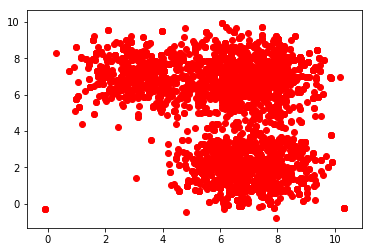

In [9]:
# Plot = True
Q = lambda x: multivariate_normal.rvs(x, 5* np.identity(2)) 
Metropolis_hasting(mixture_d_2,1000,Q)

With those methods, the advantage is that we can generate points from the density. Here we have a very good set of points that describes the gaussians and the weight of each of them with the number of points in each cluster. But it does not directly give the mean or the distribution. One may think of using K-Means or EM algorithm to determine the distribution with previous points as inputs (cf [Annex](#section5)). But here since we study Monte-Carlo methods, we stick to this approach. 

# II) Importance sampling<a name="section2"></a>

In this section, we discuss importance sampling methods that aims at maximazing a cost function on a family of distributions. So for paramatric methods, we are not able to generate points as for Metropolis-Hasting methods but we can study interesting properties of those methods.


## 4) Kullback-Leibler estimation<a name="paragraph4"></a>

**First idea:** Use the Kullback Leibler criteria applied to the family of normal distribution Q. 

The problem is :

$$max_{q \in Q} \int log(q) \frac{f}{q_0}$$

Hence, the law is pretty simple with likelihood considerations.


We can consider the distribution as $\mathcal{N}(\mu,\Sigma)$ with :
$$\hat{\mu} = \frac{1}{n} \sum_{i=1}^{n} \omega_{i,n} X_i$$

$$\hat{\Sigma} = \frac{1}{n} \sum_{i=1}^{n} \omega_{i,n} X_i X_i^T$$

avec $\omega_{i} = \frac{f(X_i)} {q(X_i)}$ et $\omega_{i,n} = \frac{\omega_i} {\sum\limits_{i=1}^{n} \omega_i}$

We have more or less the same estimators if we consider Student distributions and GMM methods.

**Algorithm:**
_Inputs:_ $f$ density of integration, $fun$ the function to integrate (here identity), $q_0$ uniform law here in $[-10,10]$, $n$ the budget ($n_1$ and $n_2$ choosen as $[\sqrt{n}]$ and $n - [\sqrt{n}]$ respectively)

_Outputs:_ $\frac{1}{n_2} \sum_{i=1}^{n_2} \frac{f(Y_i)}{q(Y_i)} \: fun(Y_i)$ avec $Y_i \sim \mathcal{N}(\hat{\mu},\hat{\Sigma})$ 

In [16]:
#likelihood estimators of mean and covariance matrix
def ml1(x,f,dim,n0):
    mu = np.zeros(dim)
    s = 0
    for i in range(n0):
        s += abs(f(x[i][:]))
        mu += abs(f(x[i][:])) * x[i][:]
    return (mu / s,s)
                                
def ml2(x,f,dim,n0,mu,weight):
    s = weight
    sigma = np.zeros((dim,dim))
    for i in range(n0):
        u = np.array(x[i][:] - mu)[np.newaxis]
        sigma += abs(f(x[i][:])) *  np.dot(u.T,u) #may not be covariance matrix because of weighted sum
    return sigma / s

def multivariate_student(mean,cov,nb,k=3):
    n = len(mean)
    z = np.random.multivariate_normal(np.zeros(n),cov,nb)
    u = norm.rvs(0,1,k)
    y = 0
    for i in range(k):
        y += u[i]**2
    y = y / k
    #print((np.ones((nb,1)) * mean))
    z = 1 / math.sqrt(y) * z + (np.ones((nb,1)) * mean)
    return z

def multivariate_student_pdf(x,mean,cov,k=3):
    p = len(mean)
    r = math.gamma((k + p)/2) / (math.gamma(k / 2)) / (k * math.pi)**(p/2) / math.sqrt(abs(np.linalg.det(cov)))
    u = (x - mean)
    f = 1 / k * (u.transpose()).dot((np.linalg.inv(cov)).dot(u))
    f += 1
    f = r * f**(-(k + p)/2)
    return f

In [17]:
def KLSample(f,n,fun = identity,dim = 2, dist = "Gaussian", bound = 10,Plot = False):
    n1 = math.floor(math.sqrt(n)) #can be changed
    n2 = n - n1
    x = 2 * bound * np.random.random_sample((n1,dim)) - bound 
    r = np.zeros(dim)
    g = lambda x : f(x) / uniform(x,bound,dim)
    #compute estimators
    alpha = ml1(x,g,dim,n1)
    mu = alpha[0]
    sigma = ml2(x,g,dim,n1,mu,alpha[1]) 
    if dist == "Gaussian":
        y = np.random.multivariate_normal(mu,sigma,n2)
        g = lambda x: multivariate_normal.pdf(x,mu,sigma)
    else:
        y = multivariate_student(mu,sigma,n2)
        g = lambda x: multivariate_student_pdf(x,mu,sigma)
    if Plot:
        plotter(f,y)
    #calculate the sampling result with the point from stage exploit
    for i in range(n2):
        r += f(y[i,:]) / g(y[i,:]) * fun(y[i,:])
    return r / n2

## 5) AIS with Gaussian or Student distributions<a name="paragraph5"></a>

Given the previous algorithm, one can think of computing the derived adaptative importance sampling. The main point is to use the points generated at each stage for computing a new density that will be used in our function.

We choose here a constant allocation policy given $T$, the total budget is $N = T \times n$ where n is the number of points generated at each stage.

**Algorithm:**
_Inputs:_ $f$ density of integration, $fun$ the function to integrate (here identity), $q_0$ t distribution density for exploration, $N$ the budget, $T$ the number of stages (in the code nb)

_Step at stage n°k:_

* Compute the mean and covariance estimators with weights $w_{i,n} = f(X_i^{(k)}) / q_{k-1}(X_i^{(k)})$  with $X_i^{(k)}$ generated with the density in the previous stage
* Generate n points with those estimated parameters (that maximize the cost function)
* Use all the points generated so far for calculating an approximation of the integral
* Update the density $q_k$ with the estimated parameters



_Outputs:_ $\frac{1}{n_t} \sum_{j=1}^{k}\sum_{i=1}^{n} \frac{f(X_i^{(j)})}{q_{j-1}(Y_i^{(j)})} \: fun(Y_i^{(j)})$ avec $Y_i^{(j)}$ generated according to Student distribution or Gaussian distribution with the mean and covariance estimators at every stage $j \leq k$ for all k.

In [32]:
# based on Gaussian distribution
def AIS(f,Nb,fun = identity,dim = 2,nb = 50,dist = "Student",bound = 10):
    n1 = Nb // nb #can be changed
    x = multivariate_student(bound / 2 * np.ones(dim),0.5 * np.identity(dim),n1)
    r = np.zeros(dim) #the sum value at each stage of AIS
    integral = np.zeros((nb,dim))
    q = lambda x: uniform(x,bound,dim)
    nt = n1
    for i in range(nb-1):
        g = lambda x : f(x) / q(x)
        # computation of the estimators
        alpha = ml1(x[(nt - n1):,:],g,dim,n1)
        mu = alpha[0]
        sigma = ml2(x[(nt - n1):,:],g,dim,n1,mu,alpha[1])
        if dist == "Gaussian":
            y = np.random.multivariate_normal(mu,sigma,n1)
        else:
            y = multivariate_student(mu,sigma,n1)
        x = np.concatenate((x,y))
        for j in range(nt,nt + n1):
            r+= g(x[j,:]) * fun(x[j,:])
        nt += n1
        integral[i,:] = r / nt
        if dist == "Gaussian":
            q = lambda x: multivariate_normal.pdf(x,mu,sigma)
        else:
            q = lambda x: multivariate_student_pdf(x,mu,sigma)
    return integral

In [109]:
# bizarre mix generation student, density gaussian
AIS(mixture_d_2,10000)

array([[6.2098169 , 4.55694948],
       [6.20736008, 4.72875894],
       [6.26868391, 4.785121  ],
       [6.27897339, 4.8374963 ],
       [6.23532295, 4.82296314]])

In [118]:
# Student
AIS(mixture_d_2,10000)

array([[7.02357877, 5.82451292],
       [5.5249911 , 4.59979447],
       [4.85462776, 4.0527068 ],
       [5.50798183, 4.55455824],
       [5.84705505, 4.67972694],
       [5.9634389 , 4.75224571],
       [6.0512096 , 4.80160512],
       [6.19717464, 4.99668006],
       [6.17098701, 4.95710587],
       [6.10445403, 4.94908222]])

In [129]:
# Student 50
AIS(mixture_d_2,10000)

array([[22.47089693, 23.36867266],
       [16.55420466, 16.98199871],
       [14.40543149, 14.04056265],
       [13.21970627, 12.37860742],
       [12.0378794 , 11.0315251 ],
       [11.46608853, 10.61351029],
       [11.08114507, 10.21359595],
       [10.12301233,  9.29835278],
       [ 9.99212095,  9.08738677],
       [ 9.41480409,  8.59240756],
       [ 9.21666936,  8.35489072],
       [ 9.04721998,  8.1772553 ],
       [ 8.9111445 ,  7.9695518 ],
       [ 8.77894837,  7.85056995],
       [ 8.44703569,  7.54739472],
       [ 8.3720497 ,  7.47778688],
       [ 8.21495656,  7.30191798],
       [ 8.10722494,  7.18958733],
       [ 7.86247035,  6.96200361],
       [ 7.87372156,  6.94007594],
       [ 7.86997129,  6.88956203],
       [ 7.84540336,  6.84691224],
       [ 7.60806768,  6.67356111],
       [ 7.36099783,  6.43914062],
       [ 7.3473728 ,  6.38376233],
       [ 7.20040065,  6.2775062 ],
       [ 7.1428481 ,  6.21471642],
       [ 7.13708127,  6.17955499],
       [ 7.17074535,

In [135]:
# Student 100
AIS(mixture_d_2,10000)

array([[5.04842309, 5.61283667],
       [6.2917449 , 6.66780772],
       [5.57532484, 5.33277625],
       [5.03550097, 4.83816277],
       [5.31963279, 4.91605996],
       [5.58514175, 5.00098206],
       [5.67961361, 5.02193728],
       [5.89708709, 5.10557329],
       [6.01553515, 5.07345161],
       [6.04690985, 4.96686386],
       [5.90186713, 4.76322984],
       [5.89144766, 4.77240814],
       [6.04518802, 4.85688642],
       [6.11519883, 4.8607    ],
       [6.08064933, 4.9173909 ],
       [6.2402168 , 5.07728215],
       [6.34894244, 5.2091131 ],
       [6.41114014, 5.18667548],
       [6.12148606, 4.97486256],
       [6.26301764, 5.15318879],
       [6.23216567, 5.11364631],
       [6.18782655, 5.11380727],
       [6.12448804, 5.00575033],
       [6.22961525, 5.13787234],
       [6.29122661, 5.14213134],
       [6.23578013, 5.09974251],
       [6.32506005, 5.14924646],
       [6.35584173, 5.19701767],
       [6.19435567, 5.07194245],
       [6.20478037, 5.08374023],
       [6.

With these examples, we can already notice the decreasing error at each stage with AIS method as expected. 

## 6) Non parametric AIS<a name="paragraph6"></a>

The main problem of parametric estimation of the integral is that we are limited to some families of distributions. What's more it is also difficult to compute those parameters if we consider weighted sum of densities. 
Hence we think about non parametric AIS that use the nice properties of kernels.

**Algorithm:**
_Inputs:_ $f$ density of integration, $fun$ the function to integrate (here identity), $q_0$ t distribution density for exploration, $N$ the budget, $T$ the number of stages (in the code nb)

_Step at stage n°k:_

1) Compute the mean and covariance estimators with weights $w_{i,n} = f(X_i^{(k)}) / q_{k-1}(X_i^{(k)})$  with $X_i^{(k)}$ generated with the density in the previous stage

2)
* Generate n points according to multinomial random variable based on the weights: this gives the number of kernels with the same centroids to generate as samples
* Use all the points generated so far for calculating an approximation of the integral
* Update the density $q_k$ as below:

$$q_k(x) = \sum_{i=1}^{n_t} w_{i,n_t} K_h(x - X_i) $$ with $K_h(\cdot - X_i)$ a kernel describing here a multivariate normal with mean $X_i$ and covariance $I_{dim}$.
 
For commodity, we do not add the the weight of exploration points as the parameters $(\lambda)_n = 1,0,\ldots $

_Outputs:_ $\frac{1}{n_t} \sum_{j=1}^{k}\sum_{i=1}^{n} \frac{f(X_i^{(j)})}{q_{j-1}(Y_i^{(j)})} \: fun(Y_i^{(j)})$ avec $Y_i^{(j)}$ generated according to Student distribution or Gaussian distribution with the mean and covariance estimators at every stage $j \leq k$ for all k.

_Used techniques:_ The multinomial draw is meant to simulate the weighted sum of density. Indeed, 

$$f_B(x) = \sum_{i=1}^{n_t} B_i K_h(x - X_i)$$ with $B_i$ random variable (values in $\mathbb{N}$, whose sum equals to 1, $(B_i)_{(i = 1,\ldots,n)} \sim Mult(\{w_{i,n_t}, i \leq n_t\})$ 

We can approximate by its expectation:

$$\mathbb{E}[f_B(x)] = \sum_{i=1}^{n_t} \mathbb{E}[B_i] K_h(x - X_i) = \sum_{i=1}^{n_t} w_{i,n_t} K_h(x - X_i)$$

Hence, to simulate the law, we can just generate a point from $ K_h(\cdot - X_{B_i})$ if $B_i = 1$.

Because at each stage in the implemented algorithm we need to draw $n$ points, we can take $\sum_{i=1}^{n}B_i = n$ as it corresponds to n independent draws of $B_i = 1 $or $0$. And we add $B_i$ times $X_{i}$ to the points for evaluation for the next steps (generation of points).

_Technical problems:_ One of the main problem is the computation of the sum of function here. I chose to evaluate it as a function but maybe it is better to keep track of that function in the loop in an array of value (that makes the grid) as it is meant to be displayed. Netherless, as one of the advantages of keeping the function as lambda is to have a density as outputs, I kept it even though I knew it would take some time to compute as well as evaluating a multinomial draw from the vector of weights that keeps increasing at every stage.  

In [94]:
def kernel_gaussian(u,h):
    return norm.pdf(np.linalg.norm(u)**2)

def gamma(n):
    if n < 3:
        return 1
    else:
        return (1/10)**(100*n)

def add_fun(fun1,fun2):
    return lambda x: fun1(x) + fun2(x)

# choice of h_n = 1, Kernel gaussian
def NPAIS(f,Nb,fun = identity,dim = 2,nb = 5,dist = "Gaussian",bound = 10,Plot = True):
    n = Nb // nb
    h = 1
    nt = n
    x = np.zeros((Nb,dim))
    x[:nt,:] = 2 * bound * np.random.random_sample((n,dim)) - bound
    q0 = lambda x: uniform(x,bound,dim)
    q = q0
    W = []
    factor = 1
    r = np.zeros(dim)
    integral = np.zeros((nb,dim))
    for k in range(nb-1):
        newWeight = [f(x[i,:]) / q(x[i,:]) for i in range(nt - n,nt)]
        W = W + newWeight
        # normalization of current q for the computation of the update 
        q1 = lambda x: factor * q(x)
        factor = sum(W)
        w = [W[i] / factor for i in range(nt)]
        q = lambda x: q1(x) / factor
        B = multinomial.rvs(n,w)
        q1 = lambda x: 0
        for i in range(nt - n,nt):
            weight = w[i]
            mean = x[i,:]
            q2 = lambda y: weight * multivariate_normal.pdf(y,mean,h*np.identity(dim))
            q1 = add_fun(q1,q2) 
        if (k > 0):
            q = add_fun(q,q1)
        else:
            q = q1
        index = nt
        for i in range(nt):
            b = B[i]
            if b > 0:
                x[index:(index + b),:] = np.random.multivariate_normal(x[(nt + i),:],h * np.identity(dim),b)
                index += b
        if Plot:
            plotter(q,x[nt:(nt+n),:])
        for i in range(nt,nt+n):
            r += f(x[i,:]) / q(x[i,:]) * fun(x[i,:])
        nt += n
        integral[k,:] = r / nt
    return integral

In [ ]:
NPAIS(mixture_d_2,500)

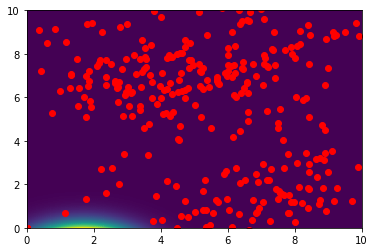

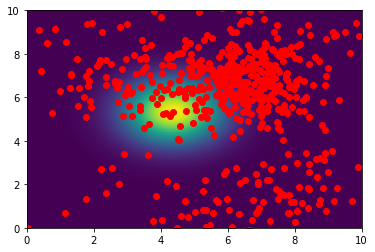

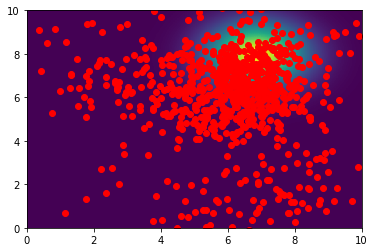

ValueError: could not broadcast input array from shape (4,2) into shape (0,2)

In [10]:
# Trial that failed because not the number of stages are not well configured
NPAIS(mixture_d_2,1000)

In [24]:
# choice of h_n = 1, Kernel gaussian
def NPAIS_simple(f,Nb,fun = identity,dim = 2,nb = 5,bound = 10,Plot = True):
    n = Nb // nb
    h = 1
    nt = n
    x = np.zeros((Nb,dim))
    x[:nt,:] = multivariate_student([bound / 2, bound / 2],0.5 * np.identity(dim),n)
    q0 = lambda x: uniform(x,bound,dim)
    q = q0
    W = []
    factor = 1
    r = np.zeros(dim)
    integral = np.zeros((nb-1,dim))
    for k in range(nb-1):
        W = [f(x[i,:]) / q(x[i,:]) for i in range(n)]
        #q = lambda x: 0
        factor = sum(W)
        w = [W[i] / factor for i in range(n)]
        B = multinomial.rvs(n,w)
        q = lambda x: 0
        index = nt
        for i in range(n):
            weight = w[i]
            mean = x[i,:]
            q2 = lambda y: weight * multivariate_normal.pdf(y,mean,h*np.identity(dim)) 
            b = B[i]
            if b > 0:
                x[index:(index + b),:] = np.random.multivariate_normal(x[nt+i,:],h * np.identity(dim),b)
                index += b
        q = add_fun(q,q2)
        nt += n    
        if Plot:
            plotter(q,x[:nt,:])
        for i in range(nt):
            r += f(x[i,:]) / q(x[i,:]) * fun(x[i,:])
        integral[k,:] = r / nt
    return integral   

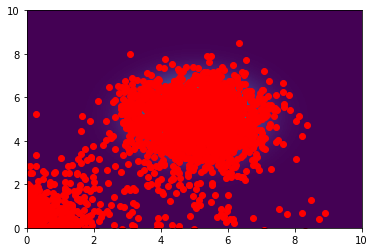

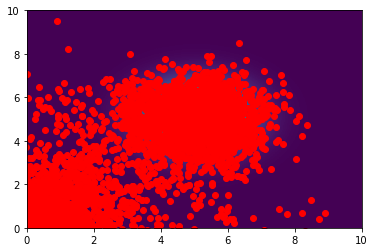

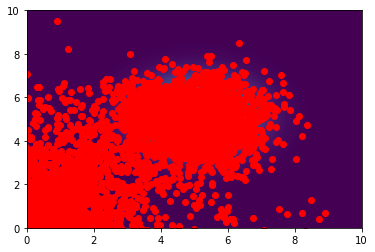

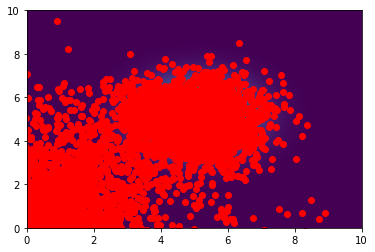

array([[-6.19339402e+14, -1.00787253e+16],
       [-5.60157316e+15, -9.11567675e+16],
       [-8.09268947e+15, -1.31695790e+17],
       [ 1.11015270e+16, -6.18830690e+18]])

In [25]:
#Could not work because the forgotten points at each stage to compute the density makes the guassians moving from spot to 
#other spot : it is like forgetting previous spot of importance at each stage so the results are not great.  
NPAIS_simple(mixture_d_2,10000)

One of the main problem is that the non parametric AIS algorithm is too long to execute since the computation of the density is more complex (as a sum of densities) for the same budget. However it also gives a representation of the density at the same time, so it might be useful as for a mapping of a density. It seems to give a good repartition of points for the _NPAIS method_, but it takes way too much time. So I cannot test it over 50 realizations. 

# III) Control variates

In this section, we deal with control variates method. I implemented Owen method to see how it performs. I used the density of normal distribution less one as the variates. 

In [91]:
def control_variates(f,N,fun = identity,dim = 2,bound = 10):
    beta = np.zeros(dim)
    x = 2 * bound * np.random.random_sample((N,dim)) - bound
    h = lambda x: multivariate_student_pdf(x,np.zeros(dim),np.identity(dim)) - 1
    A = 0
    integral = np.zeros(dim)
    for i in range(N):
        A += h(x[i,:])**2
    for i in range(N):
        beta += h(x[i,:]) * fun(x[i,:])
    beta = beta / A
    g = lambda y : f(y) * fun(y)
    print("Beta",beta)
    for i in range(N):
        integral += g(x[i,:]) - h(x[i,:]) * beta
    return (2 * bound)**(dim) * integral  / N

Here I only chose one function $h_k$ whose integral is zero. It may not be enough. Moreover, I try to apply to 2d data. Then, since the results are not coherent it is maybe due to the high values of h (Gaussian - 1).

In [93]:
control_variates(mixture_d_2,10000)

Beta [0.10263568 0.07391891]


array([46.95368096, 34.34168006])

The family of function $h_k$ may not be well chosen here. I saw in one research paper one may take Legendre polynomials.

# IV) Performances of the algorithms<a name="section4"></a>

## 7) Comparison of algorithms to the basic MC methods with uniform sampling on the cube $[0,10]^2$ <a name="paragraph7"></a>
(note that such a method neglects the mass outside the cube)

The comparison will be made with respect to a budget of $10000$ particles using the average squared error computed over at least $50$ trials.

In [35]:
errorMC = errorMethod(MC,mixture_d_2)
errorMC

<function MC at 0x000001E216CF66A8>  mean:  [6.19420521 4.97949646]
Standard error:  0.3112555566785684


(0.09688002156328551, 145.1053762435913)

In [10]:
# Gaussian Kernel (symmetric)
u = [[5,4],[3,7],[2,9],[6,5],[0,0]]
Q = lambda x: multivariate_normal.rvs(x, 5* np.identity(2)) 
errorHasting = errorMethodMCM(Metropolis_hasting,mixture_d_2,Q,u)
errorHasting

<function Metropolis_hasting at 0x000001DCC9079B70>  mean:  [6.21516208 4.95959149]
Standard error:  0.1682393887821888


(0.028304491937804474, 401.9209096431732)

In [17]:
# Gaussian Kernel (symetric)
u = [[5,4],[3,7],[2,9],[6,5],[0,0]]
Q = lambda x: multivariate_normal.rvs(x, 3* np.identity(2)) 
errorHasting2 = errorMethodMCM(Metropolis_hasting,mixture_d_2,Q,u)
errorHasting2

<function Metropolis_hasting at 0x0000024A03168AE8>  mean:  [6.20673989 5.01566511]
Standard error:  0.1841302039553169


(0.033903932008626604, 2210.549712896347)

In [45]:
# Gaussian Kernel (symetric)
u = [[5,4],[3,7],[2,9],[6,5],[0,0]]
Q = lambda x: multivariate_normal.rvs(x, 3* np.identity(2)) 
errorHasting2 = errorMethodMCM(Metropolis_hasting,mixture_d_2,Q,u)
errorHasting2

<function Metropolis_hasting at 0x0000018494A759D8>  mean:  [6.17914279 5.02847341]
Standard error:  0.40629784132413493


(0.16507793586465191, 78.04039716720581)

In [52]:
errorKL = errorMethod(KLSample,mixture_d_2)
errorKL

<function KLSample at 0x000002D12A0C1488>  mean:  [6.1247616  4.93899287]
Standard error:  0.4349220376342936


(0.1891571788199659, 209.0188980102539)

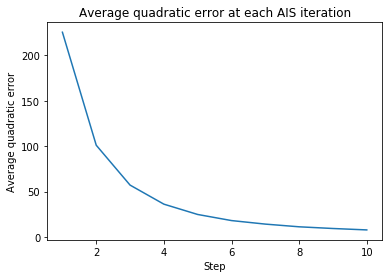

<function AIS at 0x000002D12A2A89D8>  mean:  [8.05388697 6.75223494]
Standard error:  13.768032347564764


(189.55871472358973, 655.8344452381134)

In [120]:
# Student T = 10
errorAIS = errorMethodAIS(AIS,mixture_d_2)
errorAIS

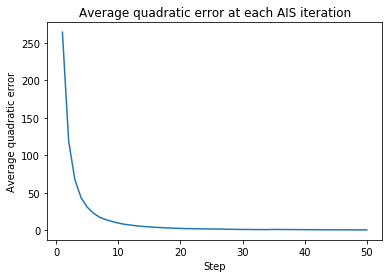

<function AIS at 0x000002D12A2A89D8>  mean:  [6.64148141 5.42364862]
Standard error:  4.390471452637529


(19.276239576425095, 671.1685476303101)

In [122]:
# Student T = 50
errorAIS2 = errorMethodAIS(AIS,mixture_d_2)
errorAIS2

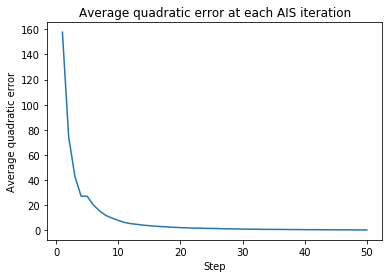

<function AIS at 0x000002D12A1E90D0>  mean:  [6.42619257 5.24839138]
Standard error:  3.636024417623149


(13.220673565551758, 691.8701112270355)

In [137]:
# Student T = 100
errorAIS3 = errorMethodAIS(AIS,mixture_d_2)
errorAIS3

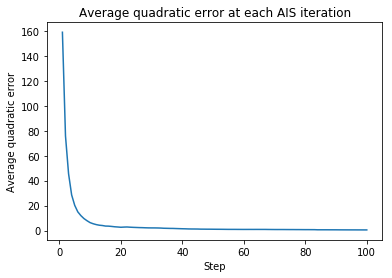

<function AIS at 0x000002D12A1E90D0>  mean:  [6.17637733 5.05547812]
Standard error:  3.434556515479047


(11.796178458019574, 689.7289667129517)

In [142]:
# Student T = 100, each step = 10000/100 = 100
errorAIS4 = errorMethodAIS(AIS,mixture_d_2)
errorAIS4

Here we can notice that even though AIS seems to converge it does not converge quickly enough to give good results. Even the 1-stage importance sampling approach seems better. The parameters for distribution do not accurately describe the density, hence the error bigger than for classic Monte-Carlo method. I could not compute AIS for Gaussian with T equal to more than 10 because of the instability of the covariance estimator. Indeed, if the number of samples in the computation of the covariance is too small, we might not get a definite positive matrix.

**Conclusion:** The AIS method seems to be interesting as the error decreases as much as we increase $T$ (as well as decreasing n = N / T), but I met difficulties to calculate the quadratic error because it does hit singular matrix sometimes. As the chart below shows, if we evaluate the performance of the methods based on time and precision, Metropolis-Hasting comes on top since it is easy to implement, does not take that much time, and gives a repartition of points on the contrary of the very fast Monte-Carlo method that does not give more information than the value of the integral. 

* Error Kullback-Leibler = 0.1
* Error Monte-Carlo = 0.09
* Error Metropolis-Hasting = 0.02

# 8) A larger dimension?<a name="paragraph8"></a>

For larger dimension, we can exclude the accept-reject method given the penalty on the constant of upper bound. Too many points are generated to be rejected. 
Let us evaluate the performance of the previous algorithms when computing the average of mixture_d_5 with different sample sizes $(1000, 5000, 10000)$. I use again the average squared error computed over at least 50 trials.


In [4]:
def mixture_d_5(x):
    x1 = np.matrix(x) - np.matrix([3,5,0,0,0])
    x2 = np.matrix(x) - np.matrix([7,5,0,0,0])
    return .5 * np.prod(norm.pdf(x1)) + .5 * np.prod(norm.pdf(x2))

Likewise, we have: $\mu = \begin{pmatrix} 5 \\ 5 \\ 0 \\ 0 \\ 0\end{pmatrix}$ the value of the integral we look for.

In [11]:
mean = [5,5,0,0,0]

Here the tests with classic Monte-Carlo.

In [12]:
errorMC = errorMethod(MC,mixture_d_5,mean,N=1000,dim = 5)
errorMC

<function MC at 0x0000019653CABD08>  mean:  [ 4.96367452  4.61637601 -0.12533781  0.01782241  0.06922304]
Standard error:  13.824458451261833


(191.11565147066474, 26.152438402175903)

In [13]:
errorMC = errorMethod(MC,mixture_d_5,mean,N=5000,dim = 5)
errorMC

<function MC at 0x0000019653CABD08>  mean:  [ 5.58798958  5.70683535 -0.04386735 -0.01442427  0.05614671]
Standard error:  6.333800944387016


(40.117034403117856, 129.44601821899414)

In [14]:
errorMC = errorMethod(MC,mixture_d_5,mean,N=10000,dim = 5)
errorMC

<function MC at 0x0000019653CABD08>  mean:  [ 4.81099242  4.78517265 -0.05359781 -0.03508893 -0.01833804]
Standard error:  3.38502031937574


(11.458362562586636, 259.5831160545349)

The results are not as good as for 2d. However, the estimation of the mean is not that bad overall.

Please find below the tests for Kullback-Leibler performance.

In [24]:
errorKL5 = errorMethod(KLSample,mixture_d_5,mean,N=5000,dim=5)
errorKL5

<function KLSample at 0x0000019653CEC950>  mean:  [ 0.0022192   0.00562761 -0.00107483  0.00138053 -0.00094949]
Standard error:  7.065645374218278


(49.92334455421214, 158.26054668426514)

In [25]:
errorKL5 = errorMethod(KLSample,mixture_d_5,mean,N=10000,dim=5)
errorKL5

<function KLSample at 0x0000019653CEC950>  mean:  [ 2.85313141e-03  4.43816736e-03 -3.23689135e-04  4.88823469e-04
 -3.70189610e-05]
Standard error:  7.06596006199545


(49.92779159771475, 275.23290610313416)

The performances are far worse With Kullback-Leibler estimation. It clearly does not fit to estimation of gaussian mixtures.
It may be efficient if the density consists in one component. 

I have troubles to test for AIS since it is based on covariance parameter that seems not to be stable at this point. So the estimated matrix is either not invertible, either singular for Student and Gaussian distribution.

In [54]:
# Gaussian Kernel (symetric)
u = [[5,4,3,7,4],[2,9,6,5,5]]
Q = lambda x: multivariate_normal.rvs(x, 3* np.identity(5)) 
errorHasting5 = errorMethodMCM(Metropolis_hasting,mixture_d_5,Q,u,mean,N=5000,dim = 5)
errorHasting5

<function Metropolis_hasting at 0x0000019653CABEA0>  mean:  [5.04690031 4.99551581 0.01857998 0.02979277 0.03002334]
Standard error:  0.43296726396996327


(0.18746065166963585, 189.25772261619568)

In [55]:
# Gaussian Kernel (symetric)
u = [[5,4,3,7,4],[2,9,6,5,5]]
Q = lambda x: multivariate_normal.rvs(x, 3* np.identity(5)) 
errorHasting5 = errorMethodMCM(Metropolis_hasting,mixture_d_5,Q,u,mean,N=10000,dim = 5)
errorHasting5

<function Metropolis_hasting at 0x0000019653CABEA0>  mean:  [4.95522982e+00 5.00422064e+00 3.32091925e-03 8.10081897e-03
 9.07574183e-03]
Standard error:  0.28698261328456065


(0.0823590203276357, 173.67865419387817)

For $10000$ samples:

* Error Monte-Carlo = 11
* Error Metropolis-Hasting = 0.08

## 9) Two new densities (respectively on $\mathbb R^2$ and $\mathbb R^5$) will be given to you during the last computer class. You will provide the accuracy (as before) of your method computing the mean with respect to these densities.

You will use $10000$ particles. And compute the average squared error with $50$ trials.

Not possible since no density has been given in class.

# V) Annex <a name="section5"></a>

**Problem :**
Here we will assume that the function is a mixture of mulitple Gaussians. Let say our densty g is of the form :
$$g(x) = \sum_{i = 1}^{m} \lambda_i f_{\mu_i,\sigma_i}(x) $$

with: $$\sum_{i = 1}^{m} \lambda_i = 1 $$

It does not seem easy to estimate those $3m - 1 $ parameters since classic likelihood consideration does not hold here.
On considère ici $m = 2$

$$g(x) = (1 - \lambda)\: f_{\mu_1,\Sigma_1}(x) + \lambda \:f_{\mu_2,\Sigma_2}(x)  $$

**EM Algorithm for 2 Gaussian mixtures:**

**Inputs:** $\varphi$ (expectation), $(x_i)_{i = 1, \ldots, n}$ sampling , g (evaluation of density), m (number of weights), $\alpha = 0.5$

**Step:**

**Parameters:** $\hat{\mu_1}$ , $\hat{\mu_2} $, $\hat{\Sigma_1}$ ,$\hat{\Sigma_2} $ , $\hat{\alpha} $

$$\hat{g}(x_i) = (1 - \hat{\alpha})\:f_{\hat{\mu_1},\hat{\Sigma_2}}(x_i) + \hat{\alpha}\:f_{\hat{\mu_2},\hat{\Sigma_2}}(x_i)$$
* Compute the responsibilities: $$\hat{\gamma}_{i} =\frac{\hat{\alpha} \:f_{\hat{\mu_2},\hat{\Sigma_2}}(x_i)}{\hat{g}(x_i)} $$

* Maximisation step (MLE):
$$\hat{\mu_1} = \frac{1}{\sum_{i = 1}^{n} (1 - \hat{\gamma}_{i})}\sum_{i = 1}^{n} (1 - \hat{\gamma}_{i}) \frac{g(x_i) } {\hat{g}(x_i)}\: x_i $$
$$\hat{\mu_2} = \frac{1}{\sum_{i = 1}^{n} \hat{\gamma}_{i}} \sum_{i = 1}^{n} \hat{\gamma}_{i} \frac{g(x_i) } {\hat{g}(x_i)}\: x_i $$

$$\hat{\Sigma_1} = \frac{1}{\sum_{i = 1}^{n} \hat{\gamma}_{i}}\sum_{i = 1}^{n} (1 - \hat{\gamma}_{i}) \frac{g(x_i) } {\hat{g}(x_i)}\: x_i \: x_i^T  $$
$$\hat{\Sigma_2} = \frac{1}{\sum_{i = 1}^{n} \hat{\gamma}_{i}} \sum_{i = 1}^{n} \hat{\gamma}_{i} \frac{g(x_i) } {\hat{g}(x_i)}\: x_i \: x_i^T $$



$$\hat{\alpha} = \frac{1}{n} \sum_{i = 1}^{n} \hat{\gamma}_{i}$$
$$\hat(g)(y) = (1 - \hat{\alpha}) f_{\mu_1,\Sigma_1}(x) + \lambda \:f_{\mu_2,\Sigma_2}(x)$$

**Iterate that step while** $(\Delta||\hat{\mu_1},\hat{\Sigma_1}|| + \Delta||\hat{\mu_2},\hat{\Sigma_2}|| > \epsilon $)

# VI) Sources


* [A guided tour in Monte Carlo, François Portier, 2019](https://sites.google.com/site/fportierwebpage/)
* [Adaptive importance sampling by kernel smoothing](https://arxiv.org/pdf/1903.08507.pdf)
* [Adaptive Importance Sampling, Art B. Owen, Stanford , 2017](http://statweb.stanford.edu/~owen/pubtalks/AdaptiveISweb.pdf)
* [Monte Carlo integration with a growing number of control variates](https://arxiv.org/pdf/1801.01797.pdf)
